In [1]:
#evaluate ekman pumping in easterlies experiment

In [2]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath
import datetime as dt
import xgcm

import xesmf
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37795,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:46631,Total threads: 1
Dashboard: /proxy/34501/status,Memory: 25.00 GiB
Nanny: tcp://127.0.0.1:43243,


In [4]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [5]:
from cosima_cookbook import explore
dbx = explore.DatabaseExplorer #(session=session)
dbx

cosima_cookbook.explore.DatabaseExplorer

In [6]:
ee = explore.ExperimentExplorer(session=master_session, experiment='01deg_jra55v13_ryf9091')
ee

ExperimentExplorer(children=(HTML(value='\n            <h3>Experiment Explorer</h3>\n\n            <p>Select a…

In [7]:
import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='gray', linewidth=0.5)

In [8]:
expt='01deg_jra55v140_iaf'

tmask = cc.querying.getvar(expt,'ht',master_session,n=1).sel(yt_ocean=slice(-90,-55))
tmask.load()
print(tmask.shape)

ht = cc.querying.getvar(expt,'ht',master_session,n=1).sel(yt_ocean=slice(-90,-55))
ht.load()
print(ht.shape)

variable='xt_ocean'
xt_ocean = cc.querying.getvar(expt,variable,master_session, n=-1)
xt_ocean.load()
print(xt_ocean.shape)

variable='yt_ocean'
yt_ocean = cc.querying.getvar(expt,variable,master_session, n=-1)
yt_ocean.load()
print(yt_ocean.shape)

variable='area_t'
area_t = cc.querying.getvar(expt,variable,master_session, n=-1)
area_t.load()
print(area_t.shape)

variable='geolon_t'
geolon_t = cc.querying.getvar(expt,variable,master_session, n=-1)
geolon_t.load()
print(geolon_t.shape)

variable='geolat_t'
geolat_t = cc.querying.getvar(expt,variable,master_session, n=-1)
geolat_t.load()
print(geolat_t.shape)

variable='geolon_c'
geolon_c = cc.querying.getvar(expt,variable,master_session, n=-1)
geolon_c.load()
print(geolon_c.shape)

variable='geolat_c'
geolat_c = cc.querying.getvar(expt,variable,master_session, n=-1)
geolat_c.load()
print(geolat_c.shape)

variable='xu_ocean'
xu_ocean = cc.querying.getvar(expt,variable,master_session, n=-1)
xu_ocean.load()
print(xu_ocean.values)

variable='yu_ocean'
yu_ocean = cc.querying.getvar(expt,variable,master_session, n=-1)
yu_ocean.load()
print(yu_ocean.shape)

variable='area_u'
area_u = cc.querying.getvar(expt,variable,master_session, n=-1)
area_u.load()
print(area_u.shape)

variable='dxt'
dxt = cc.querying.getvar(expt,variable,master_session, n=-1)
dxt.load()
print(dxt.shape)

variable='dyt'
dyt = cc.querying.getvar(expt,variable,master_session, n=-1)
dyt.load()
print(dyt.shape)

(584, 3600)
(584, 3600)
(3600,)
(2700,)
(2700, 3600)
(2700, 3600)
(2700, 3600)
(2700, 3600)
(2700, 3600)
[-279.9 -279.8 -279.7 ...   79.8   79.9   80. ]
(2700,)
(2700, 3600)
(2700, 3600)
(2700, 3600)


In [9]:
# these are the values used by MOM5
Ω = 7.292e-5     # Earth's rotation rate in radians/s
Rearth = 6371.e3 # Earth's radius in m

f = 2 * Ω * np.sin(np.deg2rad(geolat_c)) # convert lat in radians
f = f.rename('Coriolis')
f.attrs['long_name'] = 'Coriolis parameter'
f.attrs['units'] = 's-1'
f.attrs['coordinates'] = 'geolon_c geolat_c'

In [10]:
print(f.shape)

(2700, 3600)


In [11]:
start = '1958-01-01 00:00:00'
end = '2019-01-01 00:00:00'

expt='01deg_jra55v140_iaf_cycle2'

# pick the northern latitude, so there are an equal number of t-cell and u-cell gridpoint in this range:
lat_slice  = slice(-82,-50.04)

In [12]:
# topography data for plotting:
ht = cc.querying.getvar(expt,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

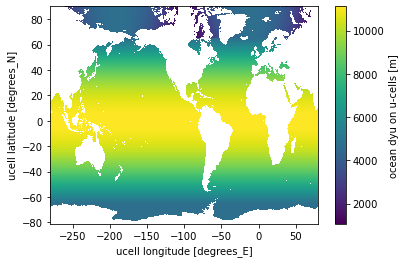

In [13]:
#dx cells are nan on all land in this expt
dyu = cc.querying.getvar(expt, 'dyu', master_session, n=1)
dyu.plot.pcolormesh()

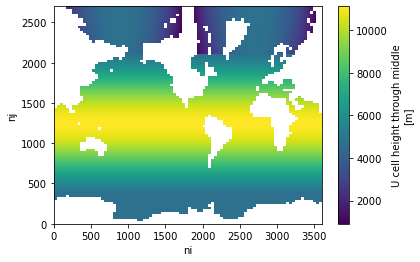

In [14]:
#this ryf expt has dx,dy values on coast
dyu = cc.querying.getvar('01deg_jra55v13_ryf9091', 'dyu', master_session, n=1)
dyu.plot.pcolormesh()

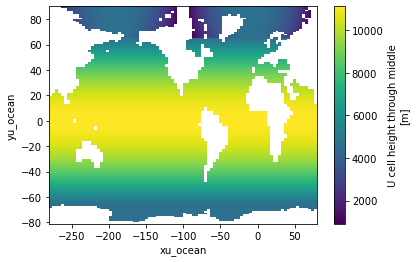

In [15]:
dyu['ni'] = xu_ocean.values
dyu['nj'] = yu_ocean.values
dyu = dyu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu.plot.pcolormesh()

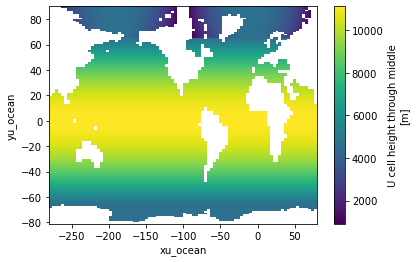

In [16]:
dxu = cc.querying.getvar('01deg_jra55v13_ryf9091', 'dxu', master_session, n=1)
dxu['ni'] = xu_ocean.values
dxu['nj'] = yu_ocean.values
dxu = dxu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu.plot.pcolormesh()

In [17]:
dyu = dyu.sel(yu_ocean=lat_slice)
dxu = dxu.sel(yu_ocean=lat_slice)

In [18]:
tau_x = cc.querying.getvar(expt, 'tau_x', master_session, frequency='1 monthly',start_time=start, end_time=end)
tau_x = tau_x.sel(time=slice(start,end)).resample({'time':'Y'}).mean('time').sel(yu_ocean=lat_slice)
tau_x = tau_x.load()

tau_y = cc.querying.getvar(expt, 'tau_y', master_session, frequency='1 monthly',start_time=start, end_time=end)
tau_y = tau_y.sel(time=slice(start,end)).resample({'time':'Y'}).mean('time').sel(yu_ocean=lat_slice)
tau_y = tau_y.load()

In [19]:
# See https://cosima-recipes.readthedocs.io/en/latest/documented_examples/RelativeVorticity.html#gallery-documented-examples-relativevorticity-ipynb
#ds = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc', combine='by_coords')
#inverse_dxtn = 0.5*(1/ds.dxu + np.roll(1/ds.dxu, 1, axis=1))
#inverse_dyte = 0.5*(1/ds.dyu + np.roll(1/ds.dyu, 1, axis=1))

# use dyu from above, because otherwise the nans from land spread:
inverse_dyte = 0.5*(1/dyu + np.roll(1/dyu, 1, axis=0))
inverse_dxtn = 0.5*(1/dxu + np.roll(1/dxu, 1, axis=0))

In [21]:
# fill land with zeros:
tauy_f = tau_y/f
tauy_f = tauy_f.fillna(0)
taux_f = tau_x/f
taux_f = taux_f.fillna(0)

# compute derivatives:
d_dx_tauyf = (tauy_f - np.roll(tauy_f, 1, axis=2))*inverse_dxtn
d_dy_tauxf = (taux_f - np.roll(taux_f, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:
d_dx_tauyf = 0.5 * (d_dx_tauyf + np.roll(d_dx_tauyf, 1, axis=1))
d_dy_tauxf = 0.5 * (d_dy_tauxf + np.roll(d_dy_tauxf, 1, axis=2))

# compute curl:
curl_tauf = d_dx_tauyf - d_dy_tauxf
curl_tauf = curl_tauf.load()

#convert from m/s to m/day
s_day=60*60*24
rho0 = 1035.
ekman = curl_tauf/rho0*s_day

ekman_taux=d_dy_tauxf.load()/rho0*s_day
ekman_tauy=d_dx_tauyf.load()/rho0*s_day

# mask land:
ekman = ekman.where(ekman!=0)
ekman_taux = ekman_taux.where(ekman_taux!=0)
ekman_tauy = ekman_tauy.where(ekman_tauy!=0)

In [22]:
# Change coords to t grid:
ekman['xu_ocean'] = ht['xt_ocean'].values
ekman['yu_ocean'] = ht['yt_ocean'].values
ekman = ekman.rename(({'xu_ocean':'xt_ocean', 'yu_ocean':'yt_ocean'}))

ekman_taux['xu_ocean'] = ht['xt_ocean'].values
ekman_taux['yu_ocean'] = ht['yt_ocean'].values
ekman_taux = ekman_taux.rename(({'xu_ocean':'xt_ocean', 'yu_ocean':'yt_ocean'}))

ekman_tauy['xu_ocean'] = ht['xt_ocean'].values
ekman_tauy['yu_ocean'] = ht['yt_ocean'].values
ekman_tauy = ekman_tauy.rename(({'xu_ocean':'xt_ocean', 'yu_ocean':'yt_ocean'}))

In [23]:
ekman

<xarray.DataArray (time: 61, yt_ocean: 665, xt_ocean: 3600)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.23556601,  0.2127295 ,  0.20166107, ...,  0.24160725,
          0.25750075,  0.25454061],
        [ 0.25519882,  0.21556888,  0.19575414, ...,  0.28657493,
          0.29416213,  0.28174575],
        [ 0.27636809,  0.23769668,  0.20346315, ...,  0.31483391,
          0.31913367,  0.30166602]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 0.0279839 ,  0.04642948,  0.04402354, ..., -0.03511976,
         -0.03955473, -0.00660539],
        [ 0.02496308,  0.03166636,  0.03956479, ..., -0.03497161,
         -0.04288012, -0.00169748],
        [ 0.01457371, -0.01115092,  0.00771403, ..., -0.05925606,
         -0.04385326,  0.01526395]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.00732253, -0.02646928, -0.03956553, ...,  0.12159519,
          0.07865837,  0.02427332],
        [ 0.01139272, -0.0244922 , -0.02703924, ...,  0.14013367,
          0.10548591,  0.06553079],
        [ 0.01350867, -0.00669633,  0.00799308, ...,  0.15089593,
          0.1223875 ,  0.07319501]]])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -50.22 -50.16 -50.09
  * time      (time) datetime64[ns] 1958-12-31 1959-12-31 ... 2018-12-31
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
    TLON      (yt_ocean, xt_ocean) float32 nan nan nan nan ... 79.75 79.85 79.95
    TLAT      (yt_ocean, xt_ocean) float32 nan nan nan ... -50.09 -50.09 -50.09
    ULON      (yt_ocean, xt_ocean) float32 nan nan nan nan ... 79.8 79.9 80.0
    ULAT      (yt_ocean, xt_ocean) float32 nan nan nan ... -50.06 -50.06 -50.06

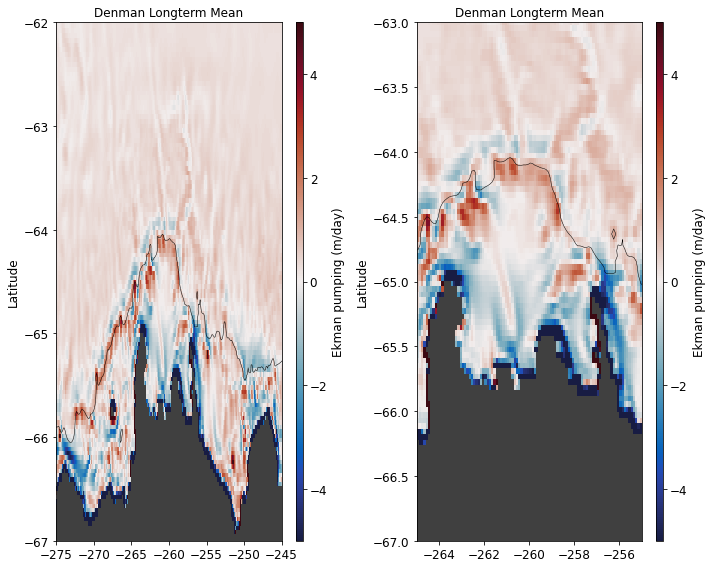

In [24]:
fontsize=12

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.gca().patch.set_color('.25')
plt.title('Denman Longterm Mean',fontsize=fontsize)
pc=plt.pcolormesh(ekman.xt_ocean,ekman.yt_ocean,ekman.mean(dim='time'),cmap=cmocean.balance,vmin=-5,vmax=5)
plt.ylim(-67,-62)
plt.xlim(-275,-245)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(1,2,2)
plt.gca().patch.set_color('.25')
plt.title('Denman Longterm Mean',fontsize=fontsize)
pc=plt.pcolormesh(ekman.xt_ocean,ekman.yt_ocean,ekman.mean(dim='time'),cmap=cmocean.balance,vmin=-5,vmax=5)
plt.ylim(-67,-63)
plt.xlim(-265,-255)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)


plt.tight_layout()

#figure_path = figdir+'/Ekman_pumping_Amundsen_zoom_yrs_2050_2164.png'
#plt.savefig(figure_path, dpi=250,bbox_inches='tight', pad_inches=0.1,facecolor='white')


In [25]:
#var.where((var.lat<5) & (var.lat>-5) & (var.lon>190) & (var.lon<240),drop=True

tmask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>1000)))
tmask = tmask.where(~xr.ufuncs.isfinite(tmask.where(yt_ocean>-60)))
tmask = ~xr.ufuncs.isnan(tmask).to_dataset(name='tmask')

#plt.xlim([-265,-254])
den_mask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>1000)))
den_mask = den_mask.where(~xr.ufuncs.isfinite(den_mask.where(yt_ocean>-60)))
den_mask=den_mask.where(~xr.ufuncs.isfinite(den_mask.where(xt_ocean<-265)))
den_mask=den_mask.where(~xr.ufuncs.isfinite(den_mask.where(xt_ocean>-254)))
den_mask = ~xr.ufuncs.isnan(den_mask).to_dataset(name='den_mask')

den_mask

<xarray.Dataset>
Dimensions:   (xt_ocean: 3600, yt_ocean: 665)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -50.22 -50.16 -50.09
Data variables:
    den_mask  (yt_ocean, xt_ocean) bool dask.array<chunksize=(540, 720), meta=np.ndarray>

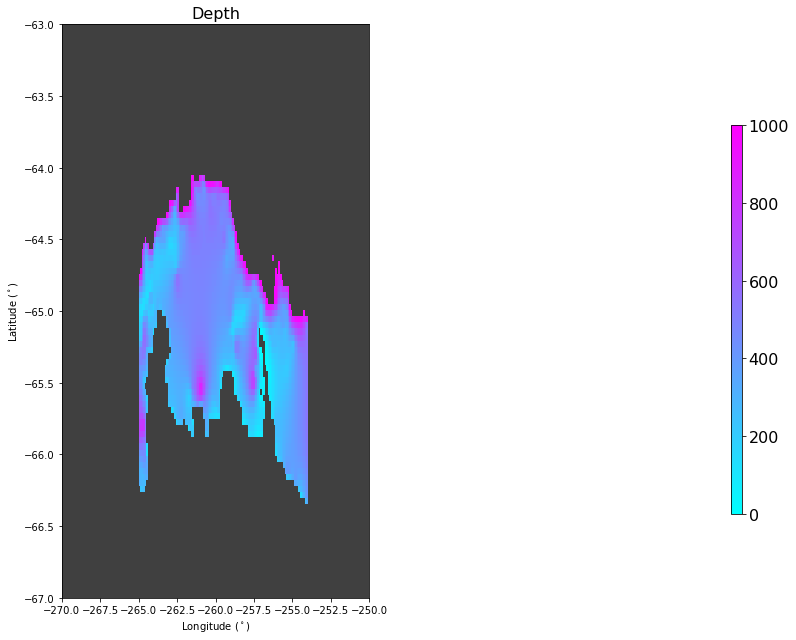

In [26]:
fig = plt.figure(figsize=(10, 9))

plt.subplot(1,2,1)
plt.gca().patch.set_color('.25')

p1 = ht.where(den_mask.den_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=0, vmax=1000, add_colorbar=False, cmap=plt.cm.cool, extend='both')

plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-67,-63])
plt.xlim([-270,-250])
plt.title('Depth',fontsize = 16)

#horiz, vert, width,height
ax = plt.axes([1.02,0.2,0.015,0.6])
cb = plt.colorbar(p1,cax=ax,orientation='vertical',shrink=0.7)
cb.ax.set_xlabel('m',fontsize=16);
cb.ax.tick_params(labelsize=16) 

plt.tight_layout()

In [28]:
#integrate Ekman pumping on the coast
#mask shelf regions
#cstmask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>300)))
#cstmask = cstmask.where(~xr.ufuncs.isfinite(cstmask.where(yt_ocean>-63)))
#cstmask = ~xr.ufuncs.isnan(cstmask).to_dataset(name='cstmask')
#cstarea=area_t.where(cstmask.cstmask).sum(dim=('xt_ocean','yt_ocean')).compute()

ekman_shelf=(ekman*area_t).where(den_mask.den_mask).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_taux_shelf=(ekman_taux*area_t).where(den_mask.den_mask).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_tauy_shelf=(ekman_tauy*area_t).where(den_mask.den_mask).sum(dim=('xt_ocean','yt_ocean')).compute()


In [29]:
np.save('../data/dm_ekman_shelf_5801to1812.npy',ekman_shelf)
np.save('../data/dm_ekman_taux_shelf_5801to1812.npy',ekman_taux_shelf)
np.save('../data/dm_ekman_tauy_shelf_5801to1812.npy',ekman_tauy_shelf)

In [30]:
tmask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>1000)))
tmask = tmask.where(~xr.ufuncs.isfinite(tmask.where(yt_ocean>-60)))
tmask = ~xr.ufuncs.isnan(tmask).to_dataset(name='tmask')

#plt.xlim([-265,-254])
vb_mask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>1000)))
vb_mask = vb_mask.where(~xr.ufuncs.isfinite(vb_mask.where(yt_ocean>-60)))

#vincennces bay
vb_mask=vb_mask.where(~xr.ufuncs.isfinite(vb_mask.where(xt_ocean<-255)))
vb_mask=vb_mask.where(~xr.ufuncs.isfinite(vb_mask.where(xt_ocean>-247)))
vb_mask = ~xr.ufuncs.isnan(vb_mask).to_dataset(name='vb_mask')

vb_mask

<xarray.Dataset>
Dimensions:   (xt_ocean: 3600, yt_ocean: 665)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -50.22 -50.16 -50.09
Data variables:
    vb_mask   (yt_ocean, xt_ocean) bool dask.array<chunksize=(540, 720), meta=np.ndarray>

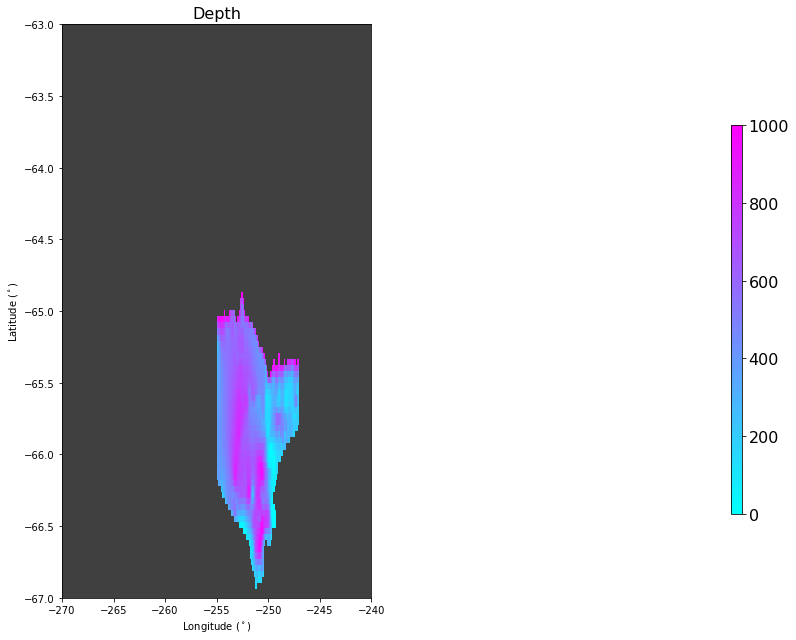

In [31]:
fig = plt.figure(figsize=(10, 9))

plt.subplot(1,2,1)
plt.gca().patch.set_color('.25')

p1 = ht.where(vb_mask.vb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=0, vmax=1000, add_colorbar=False, cmap=plt.cm.cool, extend='both')

plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-67,-63])
plt.xlim([-270,-240])
plt.title('Depth',fontsize = 16)

#horiz, vert, width,height
ax = plt.axes([1.02,0.2,0.015,0.6])
cb = plt.colorbar(p1,cax=ax,orientation='vertical',shrink=0.7)
cb.ax.set_xlabel('m',fontsize=16);
cb.ax.tick_params(labelsize=16) 

plt.tight_layout()

In [32]:
#integrate Ekman pumping on the coast
#mask shelf regions
#cstmask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>300)))
#cstmask = cstmask.where(~xr.ufuncs.isfinite(cstmask.where(yt_ocean>-63)))
#cstmask = ~xr.ufuncs.isnan(cstmask).to_dataset(name='cstmask')
#cstarea=area_t.where(cstmask.cstmask).sum(dim=('xt_ocean','yt_ocean')).compute()

ekman_shelf=(ekman*area_t).where(vb_mask.vb_mask).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_taux_shelf=(ekman_taux*area_t).where(vb_mask.vb_mask).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_tauy_shelf=(ekman_tauy*area_t).where(vb_mask.vb_mask).sum(dim=('xt_ocean','yt_ocean')).compute()


In [33]:
np.save('../data/vb_ekman_shelf_5801to1812.npy',ekman_shelf)
np.save('../data/vb_ekman_taux_shelf_5801to1812.npy',ekman_taux_shelf)
np.save('../data/vb_ekman_tauy_shelf_5801to1812.npy',ekman_taux_shelf)

In [39]:
dm_ekman_shelf=np.load('../data/dm_ekman_shelf_5801to1812.npy')
vb_ekman_shelf=np.load('../data/vb_ekman_shelf_5801to1812.npy')
print(dm_ekman_shelf.shape,vb_ekman_shelf.shape)

(61,) (61,)


In [34]:
dm_ekman_taux_shelf=np.load('../data/dm_ekman_taux_shelf_5801to1812.npy')
vb_ekman_taux_shelf=np.load('../data/vb_ekman_taux_shelf_5801to1812.npy')
print(dm_ekman_taux_shelf.shape,vb_ekman_taux_shelf.shape)

(61,) (61,)


In [35]:
dm_ekman_tauy_shelf=np.load('../data/dm_ekman_tauy_shelf_5801to1812.npy')
vb_ekman_tauy_shelf=np.load('../data/vb_ekman_tauy_shelf_5801to1812.npy')
print(dm_ekman_tauy_shelf.shape,vb_ekman_tauy_shelf.shape)

(61,) (61,)


In [36]:
def lagcorr(x,y,lag=None,verbose=True):
    '''Compute lead-lag correlations between 2 time series.

    <x>,<y>: 1-D time series.
    <lag>: lag option, could take different forms of <lag>:
          if 0 or None, compute ordinary correlation and p-value;
          if positive integer, compute lagged correlation with lag
          upto <lag>;
          if negative integer, compute lead correlation with lead
          upto <-lag>;
          if pass in an list or tuple or array of integers, compute 
          lead/lag correlations at different leads/lags.

    Note: when talking about lead/lag, uses <y> as a reference.
    Therefore positive lag means <x> lags <y> by <lag>, computation is
    done by shifting <x> to the left hand side by <lag> with respect to
    <y>.
    Similarly negative lag means <x> leads <y> by <lag>, computation is
    done by shifting <x> to the right hand side by <lag> with respect to
    <y>.

    Return <result>: a (n*2) array, with 1st column the correlation 
    coefficients, 2nd column correpsonding p values.

    Currently only works for 1-D arrays.
    '''

    import numpy
    from scipy.stats import pearsonr

    if len(x)!=len(y):
        raise('Input variables of different lengths.')

    #--------Unify types of <lag>-------------
    if numpy.isscalar(lag):
        if abs(lag)>=len(x):
            raise('Maximum lag equal or larger than array.')
        if lag<0:
            lag=-numpy.arange(abs(lag)+1)
        elif lag==0:
            lag=[0,]
        else:
            lag=numpy.arange(lag+1)    
    elif lag is None:
        lag=[0,]
    else:
        lag=numpy.asarray(lag)

    #-------Loop over lags---------------------
    result=[]
    if verbose:
        print('\n#<lagcorr>: Computing lagged-correlations at lags:',lag)

    for ii in lag:
        if ii<0:
            result.append(pearsonr(x[:ii],y[-ii:]))
        elif ii==0:
            result.append(pearsonr(x,y))
        elif ii>0:
            result.append(pearsonr(x[ii:],y[:-ii]))

    result=numpy.asarray(result)

    return result

In [37]:
def pearsoncor(y1, y2):
    ## Looking for lagged correlations between two timeseries
    ## Assumes y1 is leading
    ## Avoid end effects by using only first 2/3rds of timeseries ...???
    ## Calculates effective sample size using lag1-autocorrelations (Kial Stewart)
    ## Also, finds sampe size by a second method thanks to Josue
    
    n = len(y1)
    nc = int(n/3.5) #end effects? I don't understand this line.
    
    # De-mean both timeseries
    y1t = y1-np.mean(y1)
    y2t = y2-np.mean(y2)    

    cor = np.zeros(nc)
    sig = np.zeros(nc)
    Neff = np.zeros(nc)
    for j in np.arange(0, nc):
        x1t = np.roll(y1t, j)[j:]#y1t[:-j]
        x2t = y2t[j:]
        
        # Compute Neff for each sample using the Kial Stewart/Darryn Waugh method:
        r1, tmp = scipy.stats.pearsonr(x1t[1:], np.roll(x1t, 1)[1:])
        r2, tmp = scipy.stats.pearsonr(x2t[1:], np.roll(x2t, 1)[1:])
        Neff[j] = n*(1-r1*r2)/(1+r1*r2)
        
        cor[j], sig[j] = scipy.stats.pearsonr(x1t, x2t)
    
    #Josue's alternate Neff method
    idx = np.arange(1,nc)
    sni = np.sum((1 - idx/nc) * cor[idx])
    n_star = 1 + 2 * sni
    Neff2 = n/n_star

    return cor, sig, Neff, Neff2


#<lagcorr>: Computing lagged-correlations at lags: [0 1 2]


Text(1990, -75000000000.0, 'Max Corr. 0 Years Temp Lag, R$^2$=0.72, R=0.85, P=0.00')

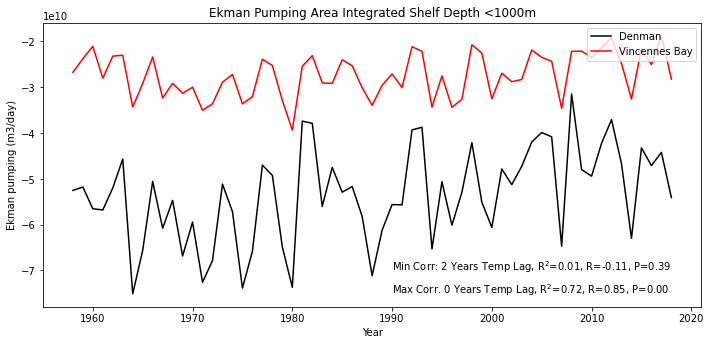

In [49]:
myr=36 #annual means start in 1958, seasonal in 59
yrs=np.arange(1958,2019,1)

fig = plt.figure(figsize=(10, 9))

plt.subplot(211)
plt.plot(yrs,dm_ekman_shelf,linestyle='-',color='k',label='Denman',linewidth=1.5)
plt.plot(yrs,vb_ekman_shelf,linestyle='-',color='r',label='Vincennes Bay',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('Ekman pumping (m3/day)')
plt.xlabel('Year')
#plt.xlim([-75,85])
plt.title('Ekman Pumping Area Integrated Shelf Depth <1000m')
plt.legend(fontsize=10,loc='upper right')

plt.tight_layout()

maxlag=2

a=dm_ekman_shelf
b=vb_ekman_shelf

#lagged cor, a lags b
l=lagcorr(a,b,maxlag)
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="Min Corr: %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
#ax1.text(1960,271.8,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
plt.text(1990,-7E10,corstr,color='k')

## Weird that SACCF is positively correlated with shelf temp ... should be negatively correlated
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="Max Corr. %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
plt.text(1990,-7.5E10,corstr,color='k')



In [52]:
dm_t_200to1000=np.load('../data/dm_temp_01_cycle2to3_200to1000_5801to1812.npy')
vb_t_200to1000=np.load('../data/vinbay_temp_01_cycle2to3_200to1000_5801to1812.npy')

In [42]:
def align_yaxis_np(ax1, ax2):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = np.array([ax1, ax2])
    extrema = np.array([ax.get_ylim() for ax in axes])
    tops = extrema[:,1] / (extrema[:,1] - extrema[:,0])
    # Ensure that plots (intervals) are ordered bottom to top:
    if tops[0] > tops[1]:
        axes, extrema, tops = [a[::-1] for a in (axes, extrema, tops)]

    # How much would the plot overflow if we kept current zoom levels?
    tot_span = tops[1] + 1 - tops[0]

    extrema[0,1] = extrema[0,0] + tot_span * (extrema[0,1] - extrema[0,0])
    extrema[1,0] = extrema[1,1] + tot_span * (extrema[1,0] - extrema[1,1])
    [axes[i].set_ylim(*extrema[i]) for i in range(2)]

(61,) (61,)
(61,) (61,)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
(61,) (61,)
(61,) (61,)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
(61,) (61,)
(61,) (61,)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]


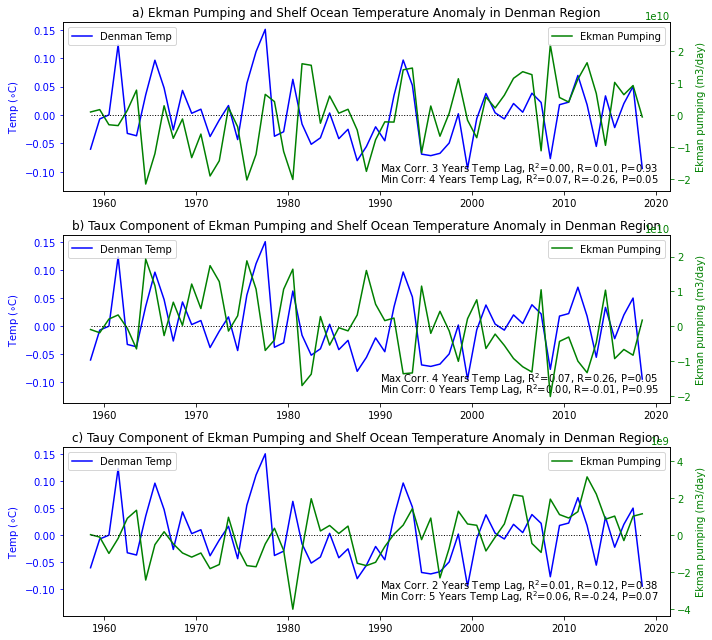

In [50]:
#load obs basal melt data for amundsen from Susheel Adusumilli (sioglaciology)
#time, melt,melt uncertainty
yrs=np.arange(1958.5,2019.5)

myr=0
maxlag=5

fig = plt.figure(figsize=(10, 9))

#take multi-cycle mean temp
ts_t=np.mean(dm_t_200to1000[:,myr:],axis=0)-np.mean(np.mean(dm_t_200to1000[:,myr:],axis=0),axis=0)
ek_t=dm_ekman_shelf-np.mean(dm_ekman_shelf,axis=0)
print(ts_t.shape,ek_t.shape)

ax1=plt.subplot(311)
ax1.plot(yrs[myr:],ts_t,linestyle='-',color='b',linewidth=1.5, label='Denman Temp')
ax1.set_ylabel('Temp ($\circ$C)',color='b')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax1.tick_params('y', colors='b')
#ax1.set_ylim((271,272))
plt.title('a) Ekman Pumping and Shelf Ocean Temperature Anomaly in Denman Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10,loc='upper left')

ax2=ax1.twinx()
ax2.plot(yrs[myr:],ek_t,linestyle='-',color='g',linewidth=1.5,label='Ekman Pumping')
ax2.plot(yrs[myr:],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#ax2.set_ylim((-8E10,-3E10))
#plt.ylim((-.3,.3))
ax2.set_ylabel('Ekman pumping (m3/day)',color='g')
ax2.tick_params('y', colors='g')
ax2.legend(fontsize=10,loc='upper right')

align_yaxis_np(ax1,ax2)


a=ts_t
b=ek_t
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(a,b,maxlag)
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="Min Corr: %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
#ax1.text(1960,271.8,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
ax1.text(1990,-0.12,corstr,color='k')

## Weird that SACCF is positively correlated with shelf temp ... should be negatively correlated
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="Max Corr. %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1990,-0.1,corstr,color='k')


#Do Taux Component
ts_t=np.mean(dm_t_200to1000[:,myr:],axis=0)-np.mean(np.mean(dm_t_200to1000[:,myr:],axis=0),axis=0)
ek_t=dm_ekman_taux_shelf-np.mean(dm_ekman_taux_shelf,axis=0)
print(ts_t.shape,ek_t.shape)

ax1=plt.subplot(312)
ax1.plot(yrs[myr:],ts_t,linestyle='-',color='b',linewidth=1.5, label='Denman Temp')
ax1.set_ylabel('Temp ($\circ$C)',color='b')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax1.tick_params('y', colors='b')
#ax1.set_ylim((271,272))
plt.title('b) Taux Component of Ekman Pumping and Shelf Ocean Temperature Anomaly in Denman Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10,loc='upper left')

ax2=ax1.twinx()
ax2.plot(yrs[myr:],ek_t,linestyle='-',color='g',linewidth=1.5,label='Ekman Pumping')
ax2.plot(yrs[myr:],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#ax2.set_ylim((-8E10,-3E10))
#plt.ylim((-.3,.3))
ax2.set_ylabel('Ekman pumping (m3/day)',color='g')
ax2.tick_params('y', colors='g')
ax2.legend(fontsize=10,loc='upper right')

align_yaxis_np(ax1,ax2)


a=ts_t
b=ek_t
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(a,b,maxlag)
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="Min Corr: %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
#ax1.text(1960,271.8,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
ax1.text(1990,-0.12,corstr,color='k')

## Weird that SACCF is positively correlated with shelf temp ... should be negatively correlated
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="Max Corr. %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1990,-0.1,corstr,color='k')

#Do Taux Component
ts_t=np.mean(dm_t_200to1000[:,myr:],axis=0)-np.mean(np.mean(dm_t_200to1000[:,myr:],axis=0),axis=0)
ek_t=dm_ekman_tauy_shelf-np.mean(dm_ekman_tauy_shelf,axis=0)
print(ts_t.shape,ek_t.shape)

ax1=plt.subplot(313)
ax1.plot(yrs[myr:],ts_t,linestyle='-',color='b',linewidth=1.5, label='Denman Temp')
ax1.set_ylabel('Temp ($\circ$C)',color='b')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax1.tick_params('y', colors='b')
#ax1.set_ylim((271,272))
plt.title('c) Tauy Component of Ekman Pumping and Shelf Ocean Temperature Anomaly in Denman Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10,loc='upper left')

ax2=ax1.twinx()
ax2.plot(yrs[myr:],ek_t,linestyle='-',color='g',linewidth=1.5,label='Ekman Pumping')
ax2.plot(yrs[myr:],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#ax2.set_ylim((-8E10,-3E10))
#plt.ylim((-.3,.3))
ax2.set_ylabel('Ekman pumping (m3/day)',color='g')
ax2.tick_params('y', colors='g')
ax2.legend(fontsize=10,loc='upper right')

align_yaxis_np(ax1,ax2)


a=ts_t
b=ek_t
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(a,b,maxlag)
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="Min Corr: %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
#ax1.text(1960,271.8,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
ax1.text(1990,-0.12,corstr,color='k')

## Weird that SACCF is positively correlated with shelf temp ... should be negatively correlated
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="Max Corr. %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1990,-0.1,corstr,color='k')


plt.tight_layout()

#of = '../data/SACCF_Temp.png'
#plt.savefig(of,dpi=220)


(61,) (61,)
(61,) (61,)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
(61,) (61,)
(61,) (61,)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
(61,) (61,)
(61,) (61,)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]


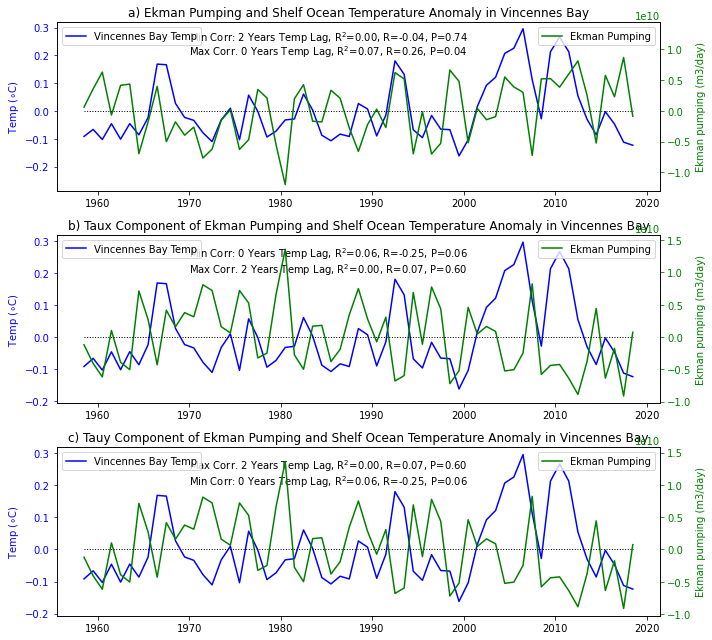

In [56]:
#load obs basal melt data for amundsen from Susheel Adusumilli (sioglaciology)
#time, melt,melt uncertainty
yrs=np.arange(1958.5,2019.5)

myr=0
maxlag=5

fig = plt.figure(figsize=(10, 9))

#take multi-cycle mean temp
ts_t=np.mean(vb_t_200to1000[:,myr:],axis=0)-np.mean(np.mean(vb_t_200to1000[:,myr:],axis=0),axis=0)
ek_t=vb_ekman_shelf-np.mean(vb_ekman_shelf,axis=0)
print(ts_t.shape,ek_t.shape)

ax1=plt.subplot(311)
ax1.plot(yrs[myr:],ts_t,linestyle='-',color='b',linewidth=1.5, label='Vincennes Bay Temp')
ax1.set_ylabel('Temp ($\circ$C)',color='b')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax1.tick_params('y', colors='b')
#ax1.set_ylim((271,272))
plt.title('a) Ekman Pumping and Shelf Ocean Temperature Anomaly in Vincennes Bay')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10,loc='upper left')

ax2=ax1.twinx()
ax2.plot(yrs[myr:],ek_t,linestyle='-',color='g',linewidth=1.5,label='Ekman Pumping')
ax2.plot(yrs[myr:],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#ax2.set_ylim((-8E10,-3E10))
#plt.ylim((-.3,.3))
ax2.set_ylabel('Ekman pumping (m3/day)',color='g')
ax2.tick_params('y', colors='g')
ax2.legend(fontsize=10,loc='upper right')

align_yaxis_np(ax1,ax2)


a=ts_t
b=ek_t
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(a,b,maxlag)
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="Min Corr: %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
#ax1.text(1960,271.8,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
ax1.text(1970,0.25,corstr,color='k')

## Weird that SACCF is positively correlated with shelf temp ... should be negatively correlated
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="Max Corr. %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1970,0.2,corstr,color='k')


#Do Taux Component
ts_t=np.mean(vb_t_200to1000[:,myr:],axis=0)-np.mean(np.mean(vb_t_200to1000[:,myr:],axis=0),axis=0)
ek_t=vb_ekman_taux_shelf-np.mean(vb_ekman_taux_shelf,axis=0)
print(ts_t.shape,ek_t.shape)

ax1=plt.subplot(312)
ax1.plot(yrs[myr:],ts_t,linestyle='-',color='b',linewidth=1.5, label='Vincennes Bay Temp')
ax1.set_ylabel('Temp ($\circ$C)',color='b')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax1.tick_params('y', colors='b')
#ax1.set_ylim((271,272))
plt.title('b) Taux Component of Ekman Pumping and Shelf Ocean Temperature Anomaly in Vincennes Bay')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10,loc='upper left')

ax2=ax1.twinx()
ax2.plot(yrs[myr:],ek_t,linestyle='-',color='g',linewidth=1.5,label='Ekman Pumping')
ax2.plot(yrs[myr:],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#ax2.set_ylim((-8E10,-3E10))
#plt.ylim((-.3,.3))
ax2.set_ylabel('Ekman pumping (m3/day)',color='g')
ax2.tick_params('y', colors='g')
ax2.legend(fontsize=10,loc='upper right')

align_yaxis_np(ax1,ax2)


a=ts_t
b=ek_t
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(a,b,maxlag)
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="Min Corr: %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
#ax1.text(1960,271.8,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
ax1.text(1970,0.25,corstr,color='k')

## Weird that SACCF is positively correlated with shelf temp ... should be negatively correlated
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="Max Corr. %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1970,0.2,corstr,color='k')

#Do Tauy Component
ts_t=np.mean(vb_t_200to1000[:,myr:],axis=0)-np.mean(np.mean(vb_t_200to1000[:,myr:],axis=0),axis=0)
ek_t=vb_ekman_tauy_shelf-np.mean(vb_ekman_tauy_shelf,axis=0)
print(ts_t.shape,ek_t.shape)

ax1=plt.subplot(313)
ax1.plot(yrs[myr:],ts_t,linestyle='-',color='b',linewidth=1.5, label='Vincennes Bay Temp')
ax1.set_ylabel('Temp ($\circ$C)',color='b')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax1.tick_params('y', colors='b')
#ax1.set_ylim((271,272))
plt.title('c) Tauy Component of Ekman Pumping and Shelf Ocean Temperature Anomaly in Vincennes Bay')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10,loc='upper left')

ax2=ax1.twinx()
ax2.plot(yrs[myr:],ek_t,linestyle='-',color='g',linewidth=1.5,label='Ekman Pumping')
ax2.plot(yrs[myr:],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#ax2.set_ylim((-8E10,-3E10))
#plt.ylim((-.3,.3))
ax2.set_ylabel('Ekman pumping (m3/day)',color='g')
ax2.tick_params('y', colors='g')
ax2.legend(fontsize=10,loc='upper right')

align_yaxis_np(ax1,ax2)


a=ts_t
b=ek_t
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(a,b,maxlag)
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="Min Corr: %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
#ax1.text(1960,271.8,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
ax1.text(1970,0.2,corstr,color='k')

## Weird that SACCF is positively correlated with shelf temp ... should be negatively correlated
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="Max Corr. %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1970,0.25,corstr,color='k')


plt.tight_layout()

#of = '../data/SACCF_Temp.png'
#plt.savefig(of,dpi=220)


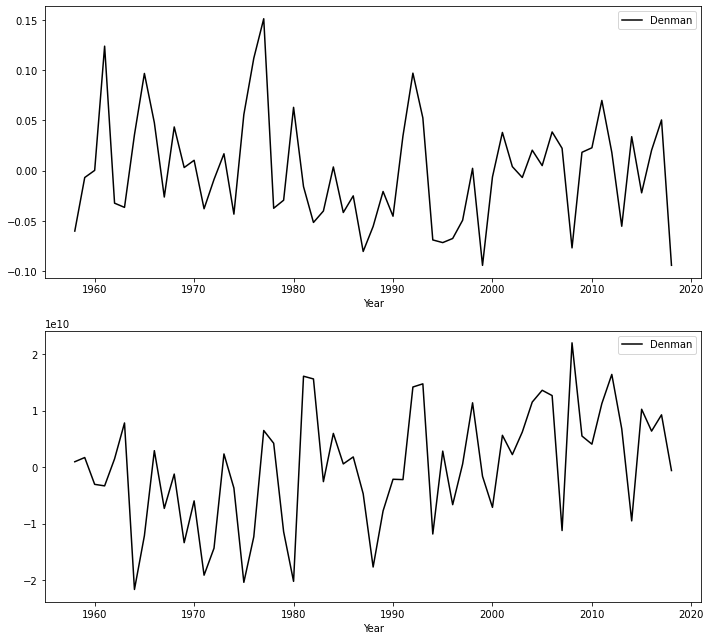

In [63]:
myr=36 #annual means start in 1958, seasonal in 59
yrs=np.arange(1958,2019,1)

fig = plt.figure(figsize=(10, 9))

plt.subplot(211)
plt.plot(yrs,ts_t,linestyle='-',color='k',label='Denman',linewidth=1.5)
#plt.ylim((1037.5,1035))
#plt.ylabel('Ekman pumping (m3/day)')
plt.xlabel('Year')
#plt.xlim([-75,85])
#plt.title('Ekman Pumping Area Integrated Shelf Depth <1000m')
plt.legend(fontsize=10)

plt.subplot(212)
plt.plot(yrs,ek_t,linestyle='-',color='k',label='Denman',linewidth=1.5)
#plt.ylim((1037.5,1035))
#plt.ylabel('Ekman pumping (m3/day)')
plt.xlabel('Year')
#plt.xlim([-75,85])
#plt.title('Ekman Pumping Area Integrated Shelf Depth <1000m')
plt.legend(fontsize=10)

plt.tight_layout()